In [8]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [9]:
#hide
from fastai.vision.all import *
from fastbook import *
import numpy as np

matplotlib.rc('image', cmap='Greys')

Under the Hood : Mnist Digit Classifier

Here we build a model from scratch using the Mnist dataset. We see how to use numpy arrays and tensors, application of broadcasting to them, , Calculating gradients, Definintion and choice of a loss function2, Updating of the weights using Stochastic Gradient Descent and the role of mini btaches.

We finally put all the math together to build a simple neural network to classify images

Download Mnist dataset
First we start by downloading the dataset

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

For the initial example, we choose to work with a subset of data to be specific we initially build a classfier to check whether an image is a 3 or 7.


In [6]:
(path/'train/3').ls()

(#6131) [Path('train/3/24672.png'),Path('train/3/1130.png'),Path('train/3/1150.png'),Path('train/3/39327.png'),Path('train/3/26478.png'),Path('train/3/14401.png'),Path('train/3/24597.png'),Path('train/3/9059.png'),Path('train/3/24451.png'),Path('train/3/48859.png')...]

# Baseline Model

## Pixel Similarity
For our baseline model, we shall use the idea of pixel similarity.
Here we find the average pixel values for every pixel position for all image groups of 3 and 7 giving us two group averages,One representing the threes and another the sevens.
This defines what we may call the "ideal" 3 and 7.

To classfify an image as a 3 or 7, we see which of these two ideal digits the image is most similar to.
We then choose an abitrairy number and measure the distance between that and our two classfication choices.

### Group averages for 3 and 7

To do this, we need to stack all the images in a folder into one tensor.

We shall use the 3's for illustration.
To stack the images, first we create a python list containing all the threes in the 3 folder.

new_list = [f(0) for o in a_list if o>1].
This returns every element in **a_list** that is **greater than 1** after applying function, **f**.

To calculate the average for each pizel position for all images, we have to combine the images into a single 3d tensor by stacking up the individual tensors in a collection into a single tensor.

PyTorch has a stack function which we can use to do this.
Some operations such as taking mean require inputs to be floats, so we cast our stacked tensor to float by typing the name of the type we want to cast to and treating it as a method.

Generally, when images are floats, the pixel values are expected to be between 0 and 1.

Finally we can compute the mean / average values for each pixel position. We do this by taking the mean of the stacked image tensor alongside dimension 0 of our stacked 3d tensor which indexes over all images.

Once we are done getting our ideal digits. We pick an abitrary 3 and measure the distance from the ideal digits.

### **Measuring distance**

How do we measure the distance from an abitrary 3 to the ideal digits?

If we just add up the differences between the pixels of the abitrary image and the ideal image. we find that some differences are positive while others are negative.

This causes the differences to cancel themselves out, resulting in an image that is too light or dark in some places being shown as having zero difference from the ideal.

To counter this, data scientist generally measure distance in this context.





1. L1 norm where we take the mean of the absolute value of differences (the absolute value is the function which replaces negative values with positive values ). This is called the mean absolute difference or L1 norm.

In [ ]:
dist_sample_3_abs = (sample_3 - mean3).abs().mean()
dist_sample_7_abs = (sample_3 - mean7).abs().mean()

In [ ]:
dist_sample_3_abs, dist_sample_7_abs

2. L2 Norm or Root mean square error, here we take the mean of the square differences (which makes everything positive), we then take the square root to undo the squaring.

In [ ]:
dist_sample_3_sqrt = ((sample_3 - mean3)**2).mean().sqrt()
dist_sample_7_sqrt = ((sample_3 - mean7)**2).mean().sqrt()

In [ ]:
dist_sample_3_sqrt, dist_sample_7_sqrt

In both cases, the distance between our abitrary 3 and the ideal 3 is less than than the distance to the ideal 7.
PyTorch provides both the L1 and L2 Norm as loss functions which you can import as F from torch.nn.functional
Mse penalizes bigger mistakes more than L1 norm while being more lenient with small mistakes.

In [ ]:
#from torch.nn.functional import F

In [ ]:
F.l1_loss(sample_3.float(),mean3),F.l1_loss(sample_3.float(),mean7)

In [ ]:
F.mse_loss(sample_3,mean3).sqrt(), F.mse_loss(sample_3,mean7).sqrt()

## NumPy Array and PyTorch Tensor data structures

(tensor(0.2021), tensor(0.3021))

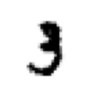

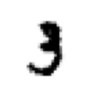

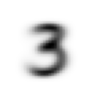

In [29]:
#qfinal
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted()

im3 = Image.open(threes[0])
im7 = Image.open(sevens[0])

im3_tens = tensor(im3)
show_image(im3_tens)

im3_tens_df = pd.DataFrame(im3_tens)
im3_tens_df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
#len(three_tensors),len(seven_tensors)

show_image(three_tensors[0])

stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

#perfect three and 7
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

show_image(mean3)

#measuring distance between random input and ideal 3, mean 3
#L1 norm or L2 norm
a_3 = stacked_threes[1]
a_7 = stacked_sevens[1]

L1_threes = (a_3 - mean3).abs().mean()
L1_sevens = (a_7 - mean3).abs().mean()

L2 = ((a_3 - mean3)**2).mean().sqrt()

#pytorch provides both these loss functions inside torch.nn.functional
F.l1_loss(a_3.float(),mean3), F.mse_loss(a_3,mean3).sqrt()
F.mse_loss(a_3,mean3).sqrt(), F.mse_loss(a_3,mean7).sqrt()



Python is a slow language compared to most, anything fast in PyTorch is probably a wrapper of an object written, compiled and optimized in another language, usually C.
C is a low level programming language, which is very fast compared to python.

A NumPy array is a multidimensional table of data of the same type. This can be any type i.e. a list, matrix, cube or even an array of arrays (jagged array).
If items are all of some simple type e.g. int, floats etc., NumPy arrays can be stored as compact c data structures in memory.
NumPy has a wide variety of operators and methods it can use to perform computation on these data structures at the same speed optimized C which is a multitude faster than Python. This is because they are written in optimized C.

A PyTorch tensor is nearly the same thing as a numpy array, with the exception that the tensor can only be of a basic numerical type / simple type such as int, float etc for example a PyTorch tensor cannot be a jagged array, it will always be a multidimensional rectangular structure.

PyTorch tensor can also live on GPU, and are also optimized for GPU, meaning it can perform faster computations given lots of values to work with.
PyTorch also supports calculating gradients which is crucial for machine learning as our loss function, weight optimizations are calculated based of the gradients.
It would be impossible to do machine learning without this ability.

In [ ]:
#Define list object
dataSet = [[1,2,3],[4,5,6]]
dataSet

In [ ]:
#convert python object to an array
dataSetArray = array(dataSet)
dataSetArray

In [ ]:
#convert python object to a tensor
dataSetTensor = tensor(dataSet)
dataSetTensor,dataSetTensor[0],dataSetTensor.type()

In [ ]:
dataSetTensor + 1

## Computing Metrics Using Broadcasting

Remember above, we have a baseline model that tells us how if a number is a 3 or 7. To do machine learning we need to know how good that model is, to do this we define a metric which is just a number that tells us how good our model is. We do this using the correct labels of the data and the predictions of the model.
We want to calculate our metric based on the validation set, as this data has not been seen by the model during training. Calculating our metric based of our training set will inadvertently lead to the model overfitting on the train set which results in poor results when the model sees new data.
Our baseline model has no training component, hence this doesn't matter but nonetheless we shall go ahead and use the validation set as a best practice.To do this we follow the same steps we did to define the training set as shown below.

We already have a value for the ideal 3 and 7, so we define a stacked tensor containing all the sevens and threes respectively in the validation set.
To calculate the distance from the ideal 7 or 3 for the whole dataset, we subtract each image from the ideal 3 just like we did for the individual image.
Broadcasting allows us to do calculations on tensor of different shapes.

In [30]:
#We stack the sevens and threes in one tensor

#qfinal
valid_threes = (path/'valid/3').ls().sorted()
valid_sevens = (path/'valid/7').ls().sorted()

valid_three_tensors = [tensor(Image.open(o)) for o in valid_threes]
valid_seven_tensors = [tensor(Image.open(o)) for o in valid_sevens]

valid_stacked_threes = torch.stack(valid_three_tensors).float()/255
valid_stacked_sevens = torch.stack(valid_seven_tensors).float()/255

We create a function mnist_distance that calculates the l1 norm/mean absolute error.

In [ ]:
def mnist_distance(a,b):
    (a-b).abs().mean((-1,-2))

#this should give us the same result as L1_threes calculated above
mnist_distance(a_3,mean3), L1_threes

In [ ]:
valid_stack

In [ ]:
ed_threes.shape(),mean3.shape()

In [ ]:
#Here the distance to the ideal image 3 from every single image in the dataset is calculated.
valid_threes_dist = mnist_distance(valid_stacked_threes, mean3)
valid_threes_dist

When we perform a simple calculation such as (a-b) on two tensors of different ranks, Broadcasting expands the smaller tensor in memory, to have the same size as the larger tensor.
It results in a value for every image expressed as a rank 1 tensor of 1,010 different values, the number of 3's in our dataset.After broadcasting , PyTorch does it usual element wise subtraction.Lets take an example


In [ ]:
tensor([1,2,3]) + tensor(1) 

This results in tensor([2,3,4]) which looks like an element wise addittion. PyTorch in this case treats tensor(1) as if it were three copies of the same tensor.Similary mean3, a rank 2 tensor representing a single image is treated as if it were 1,010 copies of the same image. It then subtracts each copy from an image in our valid_threes_dist calculating the distance between every 3 in the validation set and the ideal 3 resulting in 1,010 different values.

When PyTorch performs broadcasting, it doesnt actually copy the image 1,010 times. It just pretends that a tensor is of that shape but it doesnt actually allocate any memory for this.
PyTorch performs the whole computation in c code, and CUDA on GPU which is just C for GPU resulting in performance thousands of times faster than using pure python and millions of times faster on GPU.
This is true of all broadcasting and element wise operations and functions done in PyTorch.

Next in our function, we see .abs() which applies the method to every resulting element in a tensor returning a tensor that contains 1,010 absolute values.
Then finally we call .mean((-1,-2)) which contains a tuple of (-1,-2) which are a range of axes which represents the last and second last elements. This tells PyTorch that we want to take the mean ranging over values indexed by the last two axes of the tensor, which are the horizontal and vertical dimensions of an image. After this we are left with the first tensor axis which takes the mean over all images in the tensor, meaning we calculate the average intensity of all pixels for an image.

###is_3
We can use mnsit_distance defined above to check whether an image is a 3 or 7 by using the following logic, if the distance between the selected image and the ideal 3 is less than the distance to the ideal 7, then the number is a 3.
We define a function is_3 with the above logic

In [ ]:
def is_3(x):
    return (mnist_distance(x,mean3) < mnist_distance(x, mean7))

In [ ]:
#function returns true or false
is_3(a_3), is_3(a_3).float()

When converted to a float, True returns 1 and False returns 0. We can then run is_3 on the whole dataset.

In [ ]:
is_3(valid_stacked_threes)

Previously we used L1 normalization as a metric, but in practice we usually use metrics like accuracy that are easier to understand. We use the is_3 function over the whole dataset to calculate the accuracy by taking the average of the function for threes, and the inverse to calculate the accuracy for the sevens, as shown below.

In [ ]:
accuracy_3 = (is_3(valid_stacked_threes).float()).mean()
accuracy_7 = (1- (is_3(valid_stacked_sevens).float())).mean()
accuracy_3,accuracy_7,(accuracy_3 + accuracy_7)/2

This gives us the accuracy for all the threes. But in reality, 3 and 7 are quite similar, making it easy to classify between the two.
The model is trained to classify between 3 and 7 are also just two numbers out of 10.
To build a more robust model, we need to build a model that constantly improves, learns from the previous predictions and automatically improve itself.
To do this, we further explore the training process and Stochastic Gradient Descent (SGD).

Stochastic Gradient Descent

In 1962, Arthur Samuels described machine learning in his classic essay "Artificial Intelligence: A frontier of automation". Here he suggests that instead of telling a computer the exact steps need to solve a problem as in regular programming, we could just show a number of examples and let it figure out how to solve a problem itself. This indeed turned out to be a powerful idea, as was later shown.

Arthur Samuel's basic idea was 

Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

This spells out some powerful concepts
- The idea of weight assignment
- The fact that weight assignment has some actual performance
- The idea that there needs to be an automatic means of testing
- The need for an automatic means of improving the performance by altering the weights

This is the key to building a model that continuously gets better, unfortunately our pixel similarity lacks a learning mechanism, meaning it cannot continuously get better. To take advantage of deep learning, we represent the problem in the form Arthur Samuels described above.
To do this, we use the concepts of weights, instead of calculating the distance between the pixels of an image and the ideal image, we assign weights to each pixel whereby the highest weights are associated with the pixels that are most likely to be black.
For example, if an image is a 7, the pixels in the bottom right corner are unlikely to be activated hence the pixels in the bottom right should have a low weight assignment for a 7 while if it was an 8 or a 9 say, the pixels would be activated hence they should have a high weight assignment for 8 or 9.
\n This can be represented as a function and a set of weight values for each category, for example the probability of being an 8 can be represented as below


In [1]:
def pr_eight(x,w):
    return (x*w).sum()

Here we assume that the x is an image with the rows stacked up into one line as a single tensor. w, represents the weights. With this we just need to update the weights in such a way that the model improves, we continuously improve the weights until we can't improve them any more, or we reach the selected number of epochs/iterations. We want the values of w to be high for numbers that are actually 8 and low for numbers that are not. With this just need to find the best weights for 8 to come up with the best function that can recognize 8's.

To find the above function into a machine learning classifier, we follow the specific steps
1. We initialize the weights
2. Using set weights, we calculate whether an image is a 3 or 7 and get predictions
3. Using predictions from step 2, we calculate our loss which tell us how good our predictions are
4. Based on the above loss, we calculate our gradients, which tell us how changing the weights affects the model
5. Based on above gradients, we change the weights in the direction that improves the model
6. Go back to step 2, and repeat the process
7. Iterate until you usually stop because the model is good enough, or you are tired of waiting 

These steps are illustrated as shown below 

In [ ]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')


There are several ways to perfrom the seven steps listed above, but they all follow some general guidelines
- initilize: we usually initialize the parameters to random values and because we have a means of automatically improving the weights, it means we shall iterate towards the correct weights no matter where we start at
- Loss : This refers to the means of testing the effectiveness of any current weight assignment in terms of actual performance such that the function returns a small number if the performance is good.
- Step, how do we know if we are taking the step in the right direction, we can try adjusting the loss in any direction and see if the loss goes up and down, with this we have the direction, then we take a step in the direction using different intensities until we find which amount works best.
  Calculating gradients gives us an exact direction and number in which to adjust our weights.

lets illustrate the above steps with a simple toy example where we define a quadratic as a simple loss function and x as the weight parameter.


In [6]:
def f(x):
    return x**2

In [ ]:
#Lets plot the following equation
#help(plot_function)
plot_function(f, 'x', 'x**2')

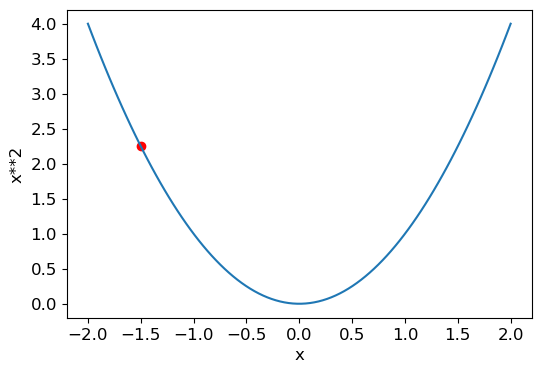

In [14]:
#As per steps above, we pick a random parameter value of -1.5 and calculate the loss.
#f(-1.5)

plot_function(f, 'x', 'x**2')
plt.scatter(-1.5,f(-1.5), color="red")

We continously adjust our model in the direction of the slope until it reasches the lowest point.We can calculate the adjustment number using gradients whcih tell us how far to adjust the weights to improve performance.

Gradients

Calculus tells us how much our loss will go up or down when we adjust our parameter values up or down.
A derivative of a function tells us about the rate of change of a function not the function value.
Remember that a function usually has a bunch of gradients, here we calculate the gradient for each weight while taking the rest as constant, then repeat this for each weight.

PyTorch can automatically calculate gradients for us but first lets pick a value where you want to calcualte derivatives of

In [11]:
#this tells pytorch to calculate gradients with respect to a variable at the value,3
#x values
xt = tensor(3.).requires_grad_()

In [17]:
#yt prints out the values and the gradient function it uses to calculate gradients when asked to
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [18]:
#backward pass/ backpropagtion where we calculate the drivatives
yt.backward()

In [19]:
#We can view the gradient by calling the grad attribute of our input tensor
xt.grad

tensor(6.)

The derivative of x**2 is 2*x, hence 2*3 results in 6 as shown above.Lets do the same for multiple values.

In [25]:
xt = tensor([3.,4.,5.]).requires_grad_()
xt

tensor([3., 4., 5.], requires_grad=True)

We redefine our function f(x) adding sum so the function takes a vector rank 1 tensor and converts into a scalar 0 rank tensor

In [28]:
def f(x):
    return (x**2).sum()

yt = f(xt)
yt

tensor(50., grad_fn=<SumBackward0>)

In [29]:
yt.backward()

In [30]:
xt.grad

tensor([ 6.,  8., 10.])

This gives us the slope of a function, they dint actually tell us how far to adjust the parameters but it gives us an idea, large slope means we still have alot of adjustment to do while a small slope means we are closer to the optimum value.

Stepping with learning rate

This involves changing the weights/parameters based on the gradients. It is commonplace to multiply the gradient values by a small number usually between 0.001 and 0.1 called the learning rate.This results in new paramter values.We can adjust the learning rate as follows

In [ ]:
w = -gradient * lr

We usually adjust our paramters in the direction of the slope as we are trying to find the minimum.The - ensures that the we increase the paramter if the slope is negative and we decrease the parameters if the slope is positive.

Example of SGD.

Here we use the gradients to find the minimum and we see how finding a minimum can be used to train a model to better fit the data.

Description
Say you are measuring the speed of a roller coaster every 20 seconds as it goes over a hill , and slopes back down.
The roller coaster would start fast, getting slower as it climbs the hill, would be slowest at the top then slowly accelerate and pick up speed as it descents down the hill.

In [32]:
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

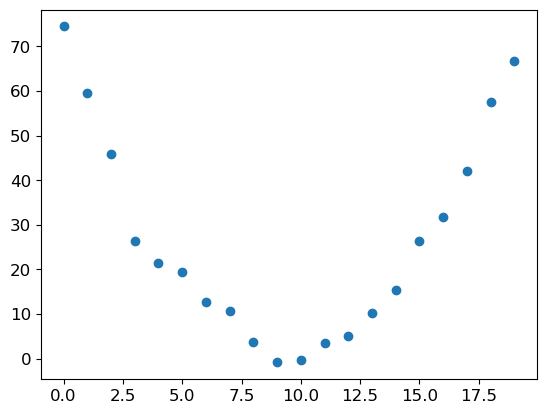

In [33]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

Using stochastic gradient descent, we can build a function that matches the data. Lets start with a quadratic in the format ax**2 + bx + c assuming that this function can fit and match our observations

In [ ]:
#time is the input and a,b,c are the parameters
a(time)**2 + b(time) + c

In [36]:
#function that takes input and parameters as input and returns a prediction
def f(t, params):
    a,b,c = params
    return a*(t**2) + b*t + c

We distinguish clearly between the functions input and the parameters in the function above. What we have done is restrict the problem of finding the best quadartic that fits to finding the best paramter values for a,b, and c which greatly simplifies our problem as every quadrastic is fully defined by 3 paramaters a,b,c.
In order to find the best quadratic function we  find the best values of a,b and c.

If we can solve the problem above, we can apply the same logic to solve other problems such as our mnist classification with more complex functions and parameters just like we are doing above. We also need to define what we mean by best values. We do this by choosing a loss function where smaller values correspond to bette predictions and vice versa.For the above continous data, we shall use mean squared error

In [37]:
#loss function
def mse(preds,targets):
    return ((preds - targets)**2).mean()
    

We now go through our seven step process

In [38]:
#intialize and tell pytorch to compute gradients
params = torch.rand(3).requires_grad_()
orig_prams = params.clone()

In [39]:
params

tensor([0.5779, 0.9040, 0.5547], requires_grad=True)

In [41]:
#Calculate predictions
preds = f(time, params)
preds

tensor([  0.5547,   2.0366,   4.6743,   8.4679,  13.4174,  19.5227,  26.7839,  35.2009,  44.7737,  55.5025,  67.3870,  80.4274,  94.6237, 109.9758, 126.4838, 144.1476, 162.9673, 182.9428, 204.0741,
        226.3614], grad_fn=<AddBackward0>)

In [42]:
len(preds)

20

In [43]:
def show_preds(preds, ax=None):
 if ax is None: ax=plt.subplots()[1]
 ax.scatter(time, speed)
 ax.scatter(time, to_np(preds), color='red')
 ax.set_ylim(-300,100)


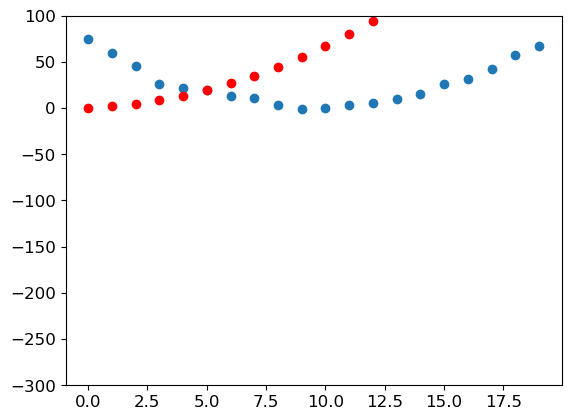

In [44]:
show_preds(preds)

In [45]:
#calculate the loss
loss = mse(preds,speed)
loss

tensor(7761.0767, grad_fn=<MeanBackward0>)

In [46]:
#calculate gradients
loss.backward()
params.grad

tensor([28189.2148,  1824.8007,   107.8606])

In [47]:
lr = 1e-5

In [48]:
i = params.data
i

tensor([0.5779, 0.9040, 0.5547])

In [49]:
u = params.grad.data
u

tensor([28189.2148,  1824.8007,   107.8606])

In [106]:
lr = 0.05
params.data = - lr * params.grad.data 

In [107]:
#new params after adjustmemt
#params.data represents the initial parameters
#params.grad.data represents the gradients of these initial paramters
# lr * params.grad.data changes multiplies the gradients of the parameters by a learning rate
#params.data = - lr * params.grad.data sets the initial parameters to the result of gradients * lr
#
i = params.data
i

tensor([-792.6697,  -51.2920,   -2.6360])

In [50]:
#step
lr = 1e-5
params.data = - lr * params.grad.data
params.grad = None

In [51]:
#go back to step 2
preds = f(time,params)
loss = mse(preds, speed)
loss

tensor(5674.8853, grad_fn=<MeanBackward0>)

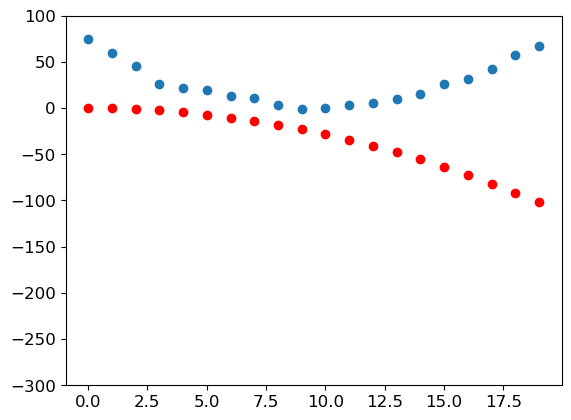

In [52]:
show_preds(preds)

In [53]:
#We need to do this a couple of times so we create one step
def apply_step(params,prn= True):
    preds = f(time,params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -=  lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [54]:
for i in range(10):
    apply_step(params)

5674.88525390625
1642.954833984375
879.9871215820312
735.607177734375
708.2830810546875
703.1094970703125
702.1275024414062
701.9385986328125
701.9000244140625
701.8897094726562


In [55]:
orig_prams

tensor([0.5779, 0.9040, 0.5547], grad_fn=<CloneBackward0>)

In [56]:
params = orig_prams.detach().requires_grad_()


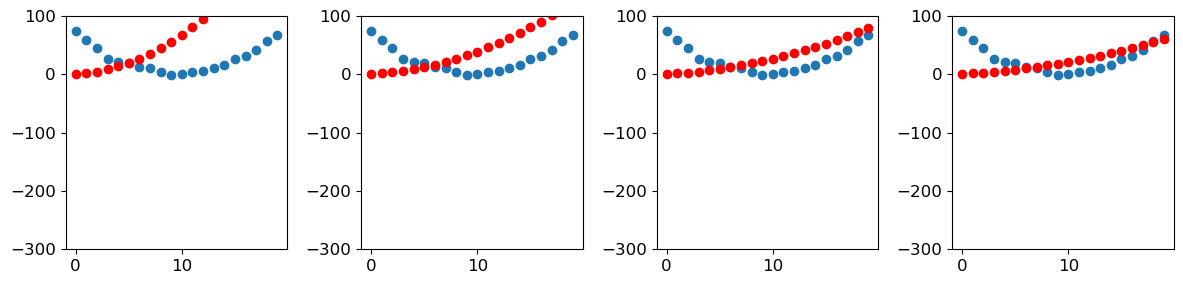

In [57]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

To summarize at the beginning, we initialize the weights to random values, since we have a means of improving them or we can use weights from a pretrained model.
In the first example, the initial weights wont be much good as well as in the second case.

Once we have weights, we can use these to calculate a prediction. We then compare our prediction with our target which in this case is our labels, which we already have as we are using a labelled dataset.
This gives us a number which we refer to as our loss, this measures the distance between the predictions and the target to tell us how good our model is.
We now have a number that we want to make as low as possible as low values of loss correspond with better predictions.

We can make the loss as low as possible by adjusting the parameters of the model also called the weights in the direction that minimizes the loss.
Calculus gives us a way to calculate which direction to adjust our weights in, calculating the gradients of the above. We adjust the weights by taking the gradients and multi[plying them by a small learning rate. We then contiously iterate until we reach the lowest point


All the above steps can be transposed and applied to the mnist dataset except the loss function. So lets now build a loss function for our mnsit dataset and apply the seven steps

##MNIST LOSS FUNCTION

We already have the independent variables, x which are the images themselves. We concatenate them into a single tensor and also change them from a list of matrices to a list of vectors, we do this using .view() a PyTorch method thay changes the shape of a tensor without changing its content. -1 is a special paramter for -1 that tells PyTorch to make this axis as big as neccesary to fit all the data.

In [60]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28)

In [ ]:
#train_x = torch.cat([all digits]).view(-1,28*28)

We also need labels for our dataset, in this case we use 1 for the 3's and 0 for the 7's.

In [69]:
#unsqueeze(1) adds an extra dimension of 1 to the train_y
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

In [ ]:
#train_y = tensor([0]*len(zeros) + [1]*len(ones) + [2]*len(twos)).unsqueeze(1)

In [70]:
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A DataSet is supposed to return a tuple of (x,y) when indexed. We can use the zip function which when combined with the list function provides a simple way to return this.

In [74]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y                    

(torch.Size([784]), tensor([1]))

In [78]:
Image.open(valid_threes[1])

In [79]:
valid_x = torch.cat([valid_stacked_threes, valid_stacked_sevens]).view(-1,28*28)
valid_y = tensor([1]*len(valid_threes) + [0]*len(valid_sevens)).unsqueeze(1)
dset = list(zip(valid_x,valid_y))


Sevens steps

In [81]:
#initiliaze parameters
def init_params(size,std=1.0):
    return (torch.randn(size)*std).requires_grad_()

#nb : what does std do in init_params function, it provides more variance in the parameters though this does nothing as it is a 1.

#https://forums.fast.ai/t/mnist-loss-function-and-prediciton/81798/4

also explains why we use weights.T which transposes the weights from a 784 * 1 to a 1 * 784 when calculating a prediction

In [82]:
weights = init_params(28*28,1)

In [ ]:
weights

The function weights * pixels wont be flexible enpough as it always returns 0 when the pixel is 0.The formula for a line is y = mx + b meaning we shall still need a b.we initilize it to a random number too.

In [84]:
bias = init_params(1)
bias

tensor([0.6653], requires_grad=True)

In a neural network the w represents the weights and the b represents the bias and together the weights and biases represent the parameters of a neural network.

In [87]:
#prediction for 1 image
pred = (train_x[0]*weights.T).sum() + bias
pred

/tmp/ipykernel_550/1078514746.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1696859728060/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  (train_x[0]*weights.T).sum() + bias


tensor([20.3636], grad_fn=<AddBackward0>)

NB: .T seems to be depreceated
/tmp/ipykernel_550/1078514746.py:2:

 UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. 

Consider `x.mT` to transpose batches of matrices 

or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. 

(Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1696859728060/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  (train_x[0]*weights.T).sum( + bias



While we could use a python for loop to calculate the predictions for each image, python for loops dont run on GPU and because python is also a slow language for loops in general, we need to represent as much of the calculation/computation in a model as possible using higher level functions as possible. 

We use matrix multiplication which is represented in python as an @ operator as shown below.

In [89]:
#a function to return predictions for all images
def linear1(xb):
    return xb@weights + bias

In [91]:
preds = linear1(train_x)
preds

tensor([20.3636, 11.2542, 11.3436,  ..., 11.0615,  4.1023, 13.1092], grad_fn=<AddBackward0>)

In [92]:
preds.shape

torch.Size([12396])

This equation batch@weights + bias is one of the two fundamental equations in deep learning with the other being the activation function which we shall see in a bit.

Lets check our accuracy.To decide whether the numbers are a 3 or 7, we just check whether its greater than 0,and our accuracy for each image is calculated using broadcasting (no loops) as shown below

In [93]:
corrects = (preds > 0.0 ).float() == train_y
corrects

tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [94]:
corrects.shape

torch.Size([12396, 12396])

In [ ]:
corrects.float().mean().item()

In [ ]:
#change one weight and calucalate the new accuracy
#torch.no_grad tells pytorch not to calculate gradients
with torch.no_grad():
    weights[0] *= 1.0001
    preds = linear1(train_x)
    (preds>0.0).float() == train_y).float().mean().item()

To improve our model using SGD, we need to calculate gradients which means we need a loss fucntion that represents hpw good our model is.The gradients are a measure of how the loss function changes with respect to the change in weights, so we definetly need a loss function.

One option would be to use accuracy, which would get the prediction for one image for every image in the dataset, calcualte the avergae accuracy over the whole dataset and then calcualte the gradients for each weight of an image with respect to the overall accuracy.

Accuracy doesnt repond to small changes in the weights hence it wont be useful as a loss function.

The gradient of a function is its slope/stepness i.e. rise over run, which is how much the value of the function goes up or down divided by how much the input changed.(y_new - y_old)/(x_new - x_old). 

This gives us a good approximation of the gradients when x_new is very similar to x_old, meaning their difference is very small. But accuracy only changes when a prediction changes from 3 to 7 or vice versa. The only problem is a small change in weights from x_old to x_new isnt likely to cause any prediction change, so y_new- y_old will almost always be 0, making the gradient 0 which is not a number a model can learn from.
Basically a small change in weights doesnt result in a change in prediction, hence the gradient at that point will almost alwaysa be zero until the precition changes.This number 0 doesnt teach the model anything.

We need a loss function which when our weights result in slighty better predictions gives us a slightly better loss.In this case if the answer is a 3, the answer is a little higher and if the answer is a 7, the loss is a little lower.

Lets write this function which takes in the predictions as input. Lets make an argument prds of values between 0 and 1, where each value is the prediction that a number is a 3.
Lets make another argument trgts which are the targets between 0 and 1 which tells whether an image is a 3 or not.
A loss function calculates the difference between the predicted images and the targets.

"calculate the loss, get gradients, update params based on grad, repeat".

For instance, we might have three numbers which are 3, 7, 3.We pass these to the model which returns prediction of (0.9) for the first where the model predicted with high confidence that the value was a 3, the second value is a (0.4) where the model was fairly confident the number was a 7, and with fair confidence but incorrectly that the last was a 7 (0.2). Since 0.9, 0.4 and 0.2 are the prediction, we pass these to the model as input.

In [ ]:
trgts = tensor([1,0,1])
prds = tensor([0.9,0.4,0.2])

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets == 1, 1-predictons, predictions).mean()

This calculates the distance between the target and 1 if it is supposed to be a one and the distance to 0, if its is supposed to be a 0. We then take the mean of those distances.

Lets try it on our prds and tgts

In [ ]:
torch.where(trgts == 1, 1-prds, prds)

This function returns a lower number when the predictions are more accurate, when accurate predictions are more confidentand when inaccurate predicitons are less confident.We take the mean to give us a scalar for the final loss.With loss, a low number is always assuemned to be better i.e if we changed our last p[rediction from 0.2 to 0.8 inidcating high confidence in the number being a three our loss goes down as shown below.

mnist_loss([0.9,0.4,0.8],trgts)

Our mnist loss function currently assumes that the preds are between 0 and 1. we need to ensure that is true.

Luckily enough, there is a function that does just that.

Sigmoid

The sigmoid function always outputs a number between 0 and 1.It takes in any value as input and squishes it into a value between 0 and 1.

It is defined as follows

In [1]:
def sigmoid(x):
    return 1/(1+torch.exp(-x))

Luckily enough PyTorch defines a sigmoid function for us, so we dont need to define one.

In [10]:
help(plot_function)

Help on function plot_function in module fastbook:

plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6, 4))



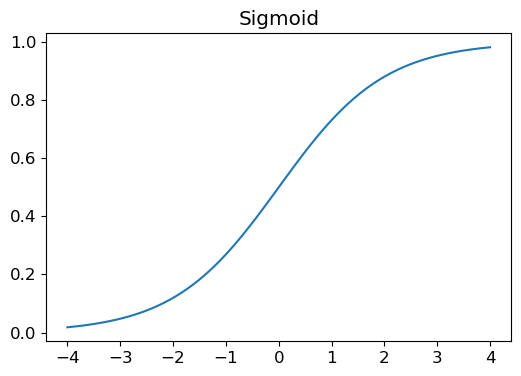

In [11]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

As we can see the above function is a smooth curve that goes up, which is the type of function that gives us meaningful derivatives.This means that the function responds to small changes in the gradients.

With this we update our mnist function as below

In [13]:
#calculates distance from 1 if target is 1,and distance from 0 if target is 0.
def mnist_loss(predictions,targets):
    predictions = prediction.sigmoid()
    return torch.where(target == 1, 1 - predictions, predictions)

With this our loss function will work even the predictions are not between 0 and 1. All that is required is that higher values of predictions correspond to s higher confidence an image is a 3.

We already have a metric so the question would be why did we define a loss function ?

A metric is used to drive human understanding of how our model is actually performing while a loss function is to drive machine learning.To drive automated learning we need a function which returns meaningful derivatives and responds to small changes in the confidence level.
This means that sometimes the loss function is not exaclty an approximation of what we want to achieve, but a compromise between the real goal and a function that can be opimtimized with gradients.

The loss function is calculated for every item in the dataset and the end of our epoch the loss values are averaged to give us a single scalar value of the mean loss for each epoch.

Metrics on the other hand show us how a model is really doing, we usually look at this  metric when judging the performance of a model.

SGD AND MINI-BATCHES

## Mnist Loss

concat all images into a single tensor. Change from matrix to vector using .view()


In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28)

We need a label for each image. we use 1 for 3 and 0 if it is a 7.

In [ ]:
train_y = tensor([1]*len(sevens) + [0]*len(threes)).unsqueeze(1)

In [ ]:
train_x.shape, train_y.shape

A dataset is supposed to return a tuple of (x,y) when indexed. We use pythons zip function combined with a list to get this functionality

In [ ]:
dset = list(zip(train_x,train_y))

In [ ]:
valid_x = torch.cat([val_stacked_threes,val_stacked_sevens]).view(-1,28*28)
valid_y = tensor([1]*len(valid_threes) + [0]*len(valid_sevens)).unsqueeze(1)
val_dset = list(zip(valid_x,valid_y))

In [ ]:
valid_x.shape,valid_y.shape

### Seven steps

#### Initialize Parameters

In [ ]:
def init_params(size,std=1.0):
    return torch.randn((size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

In [ ]:
bias = init_params(1)

In [2]:
#from y = wx + b where w is the weights
#we add bias as wx can be 0 when pixels equals 0
#single prediction
prediction = (train_x[[0]*weights.T).sum + bias

In [ ]:
#in python matrix multiplication is represented using an @
#batch@weights + bias
def linear1(xb):
    return xb@weights + bias

In [ ]:
one_prediction = linear1(train_x[0])

In [ ]:
preds = linear1(train_x)
preds

Accuracy

#### Loss function

The loss function receives argument preds as input, with each value being between 0 and 1 where each value is the prediction that an image is a 3.

Lets create another argument for trgts with each value being 1 when it is a 3 and vice versa.

Suppose we had 3 images with values being a 3, 7 and a 3.Suppose our model predicted with high confidence that our first image was a 1 (0.9) , with slight coinfidence that our 2nd image was a 7(0.4), and with fair confidence but incorrectly that the third was a 7.(0.2) meaning our loss function would receive the following values as input

In [ ]:
trgts = ([1,0,1])
prds = ([0.9,0.4,0.2])

Below we build a loss function that measures distance from the targets

torch.where(a,b,c) is the same as running the list comprehension [b[i] if a[i] is true else c[i] for i in range(len(a))]

In [ ]:
#function will measure distance from 1 if target is 1 and distance from 0 if target is 0
def mnist_loss(predictions, targets):
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

In [ ]:
#loss function should return a lower number when the predicton is correct, when accurate predictions are more confident and a higher number when the prediction is false.
torch.where(trgts == 1, 1- prds, prds)

In [ ]:
#this gives us a scalar for loss by taking the mean of the previous tensor
mnist_loss(trgts, prds)

In [ ]:
#say we change the 0.2 to 0.8 giving a more accurate predicition for the 7, i.e. 0.8 says it is highly unlikely the 3rd float in the tuple is 7
#this results in a smaller loss, meaning this is a better prediction
mnist_loss(tensor([0.9,0.4,0.8]), trgts)

One potential issue with the mnist_loss currenlty defined we assume all the preds are between 0 and 1, we need to then ensure that this is always the case. We can do this using a sigmoid function.

#### Sigmoid

This function always outputs a number between 0 and 1.It takes any input value negative or positive and squeeshes it into an output value between 0 and 1.It can be defined as follows

In [1]:
def sigmoid(x):
    return 1/(1 + torch.exp(-x))

so we update our mnist_loss to include sigmoid

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return (torch.where(targets==1, 1 - predictions, predictions))

- A metric is to drive human understanding and a loss function is to drive automated learning

Mini batches

In order to take an optimization step, we need to calculate the loss over one or more data items.Calculating the loss for one single item gives too little information to build a model for all items as the model being built would be optimized for that item whereas using all items in the dataset would take too long.

As a compromise, we take the average loss of a few data items at a time. This is called a mini batch. The number of data items in a mini batch is refered to as the batch size. and proic
A larger batch size means you will get more accurate and stable estimate of our parameter gradients from the loss, but it also takes longer and processes fewere mini batches per epoch.

Another reason for getting the gradients of parameters in mini batches as opposed to for single data items is the use of accelerated compute like GPU's which only perform well when fed many data items to work with but if you feed them to much data at once they run out of memory.

If you remember in the production chapter, we get better generalization when we vary the items we show the network when training. Hence on simple and effective thing we can do is vary the items in each mini batch. To do this rather than simply enumerating our dataset in order for every epoch, we randomly shuffle the dataset on every epoch before choosing a mini batch.
PyTorch and fastai provide a class for you called a DataLoader that does the shuffling and mini batch collation. A DataLoader can take any python collection and turn it into an iterator over mini batches for example

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size = 5, shuffle=True)
list(dl)

Putting it all together

In [ ]:
#We want to create a loop like this
for x,y in dl:
    pred = model(x)
    loss = loss_func(preds,y)
    loss.backwards()
    params.data -= params.grad * lr

In [ ]:
#step 1 
#initialize parameters
weights = init_params(28*28,1)
bias = init_params(1)

In [ ]:
#create dataloader
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [ ]:
#create mini batch
batch = train_x[:4]
batch.shape

In [ ]:
#make preds
preds = linear1(batch)
preds

In [ ]:
#calculate loss
loss = mnist_loss(preds, train_y[:4])
loss

In [ ]:
#calculate gradients
loss.backwards()
weights.grad.shape, weights.grad.mean(), bias.grad

Lets put the prediction, loss and gradient part in a function

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [ ]:
calc_grad(batch,train_y[:4], linear1)
weights.grad.mean(),bias.grad

loss.backward() actually adds up the gradients of loss to any other gradients that are stored.Because of this we usually set our weights and bias to 0.

In [ ]:
weights.grad.zero_()
bias.grad.zero_();

Our remaining step is to update our weights and biases based of the gradient values.When doing this we have to tell PyTorch not to take the gradient of this step too otherwise things get confusing when we try to take the derivative at the next step.The data attribute of a tensor signals PyTorch not to calculate gradients at a particular step.

In [3]:
#training loop for an epoch
def train_epoch(model, lr, params):
    for x,y in dl:
        calc_grad(xb,yb,model)
        for p in params:
            p.data -= p.grad.lr
            p.grad.zero_()

In [ ]:
(preds>0.0).float() == train_y[:4]


In [ ]:
#step